In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

#### Read Data

In [2]:
data1 = pd.read_csv('./BankChurners.csv')
data1 = data1.drop(columns={'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'})
data1.shape

(10127, 21)

In [3]:
data1.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


#### Dividing Dataset into Target & Features

In [4]:
x = data1.drop(columns='Attrition_Flag')
y = data1.Attrition_Flag

# Descriptive Data Analysis

Below are some of the insights that can be obtained from the dataset before buliding the prediction model

#### Distribution of Total Transactions by Gender

In [5]:
x.Gender.value_counts()

Gender
F    5358
M    4769
Name: count, dtype: int64

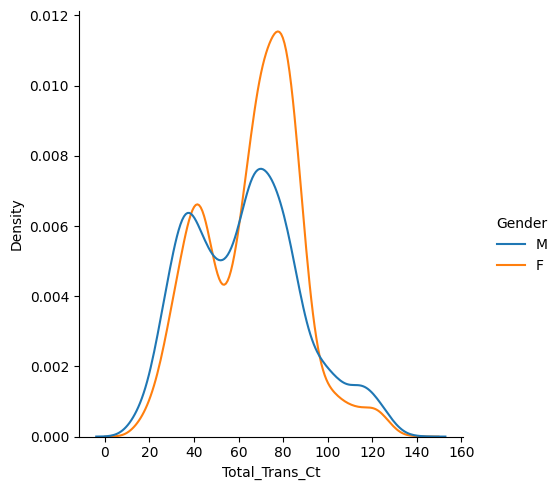

In [6]:
sb.displot(x, x='Total_Trans_Ct', hue='Gender', kind='kde')
plt.show()

The distributions of the total transactions are almost the same for Male and Female, except for the range (70,90) where we can see a significant spike in female customers in terms of number of transactions.

#### Total Transaction Amount VS Total Transactions by Target Variable

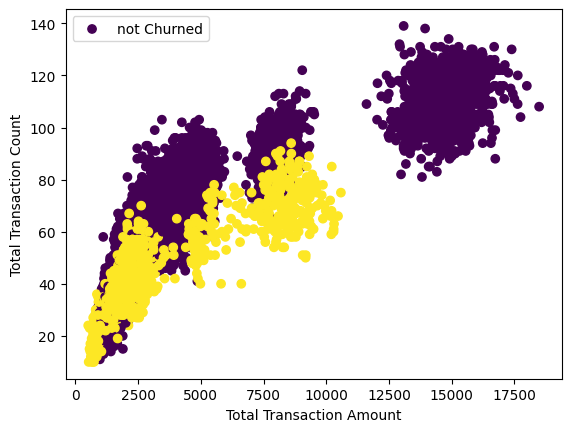

In [7]:
plt.scatter(x.Total_Trans_Amt, x.Total_Trans_Ct, c=y.replace({'Existing Customer':0, 'Attrited Customer':1}))
plt.xlabel('Total Transaction Amount')
plt.ylabel('Total Transaction Count')
plt.legend(['not Churned', 'Churned'])
plt.show()

We can clearly observe that customers with Total_Trans_Amt > 12,500 AND Total_Trans_Ct > 100 have not churned at all and even the rest of the data points we can see some clear differentiation between churned and not churned customers. So even before builiding the prediction model, we can get some understanding about how the classification might work and we can predict that total transaction amount and total transactions will be of high importance when it comes to feature importance.

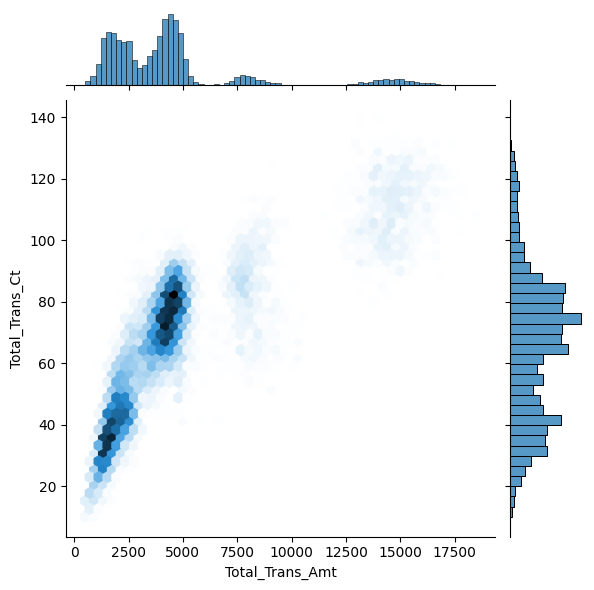

In [8]:
sb.jointplot(data=x, x='Total_Trans_Amt', y='Total_Trans_Ct', kind='hex')
plt.show()

The above joint plot with kind='hex' gives us some understanding about the density of data points which we cannot see in the scatter plot due to overlapping

#### Customer Age VS Months On Book

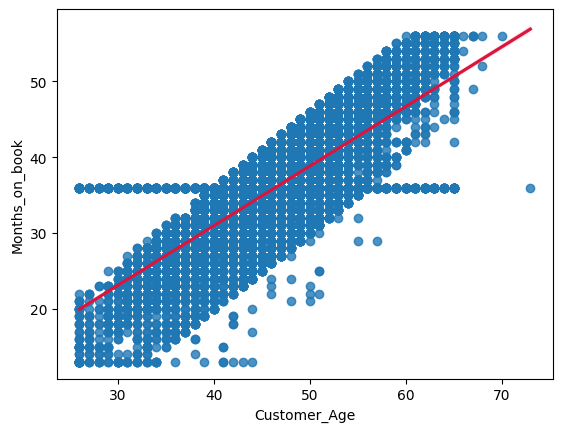

In [9]:
sb.regplot(x, x='Customer_Age', y='Months_on_book', line_kws={"color": "crimson"})
plt.show()

By looking at the regression plot, we can see a strong positive relationship between Customer_Age and Months_on_book. Later in this notebook, we can see the linear correlation coefficient between these 2 features is 0.79

#### Average Credit Limit by Gender and Age

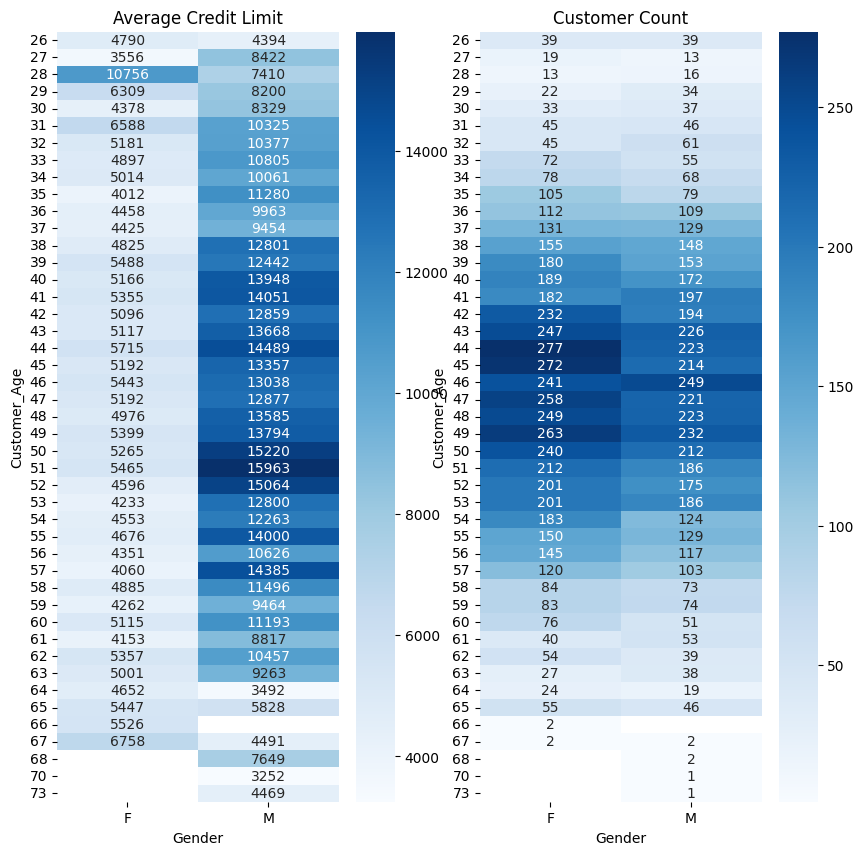

In [10]:
plt.figure(figsize=(10,10), dpi=100)
plt.subplot(1,2,1)
corr_table1 = pd.pivot_table(data=x, index='Customer_Age', columns='Gender', values='Credit_Limit', aggfunc=np.mean)
sb.heatmap(corr_table1, annot=True, fmt='.0f', cmap='Blues')
plt.title('Average Credit Limit')
plt.subplot(1,2,2)
corr_table2 = pd.pivot_table(data=x, index='Customer_Age', columns='Gender', values='Credit_Limit', aggfunc='count')
sb.heatmap(corr_table2, annot=True, fmt='.0f', cmap='Blues')
plt.title('Customer Count')
plt.show()

Average credit limit for male customers is significantly higher than that of female customers across all ages except for a few. When we consider male customers, the variance of average credit limit is greater than that of female customers. Male customers have highest average credit limits around the age of 50 and the highest for female customers is at the age of 28 which is quite suprising compared to the values of the neighboring ages.

#### Average Transactions by Marital Status and Dependent Count

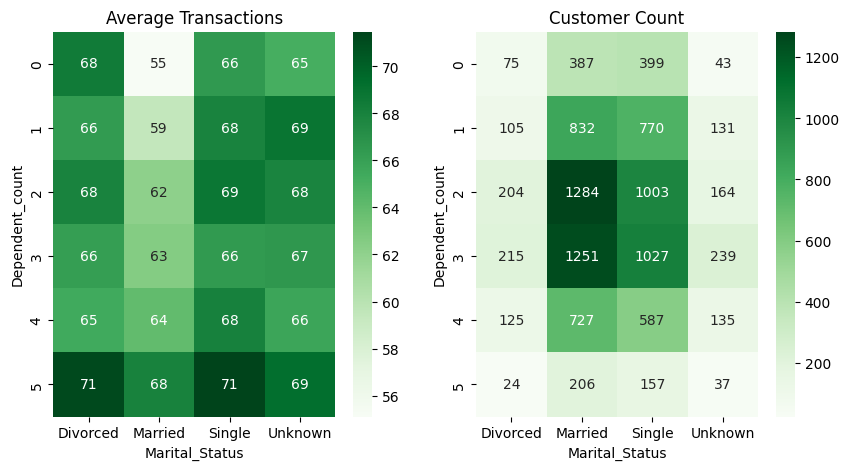

In [11]:
plt.figure(figsize=(10,5), dpi=100)
plt.subplot(1,2,1)
corr_table3 = pd.pivot_table(data=x, index='Dependent_count', columns='Marital_Status', values='Total_Trans_Ct', aggfunc=np.mean)
sb.heatmap(corr_table3, annot=True, fmt='.0f', cmap='Greens')
plt.title('Average Transactions')
plt.subplot(1,2,2)
corr_table4 = pd.pivot_table(data=x, index='Dependent_count', columns='Marital_Status', values='Total_Trans_Ct', aggfunc='count')
sb.heatmap(corr_table4, annot=True, fmt='.0f', cmap='Greens')
plt.title('Customer Count')
plt.show()

Regardless of the dependent count, married customers have the lowest average transactions. For all marital statuses, dependent count = 5 has the highest average transactions which is expected.

#### Total Transactions by Card Category 

In [12]:
x.Card_Category.value_counts()

Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64

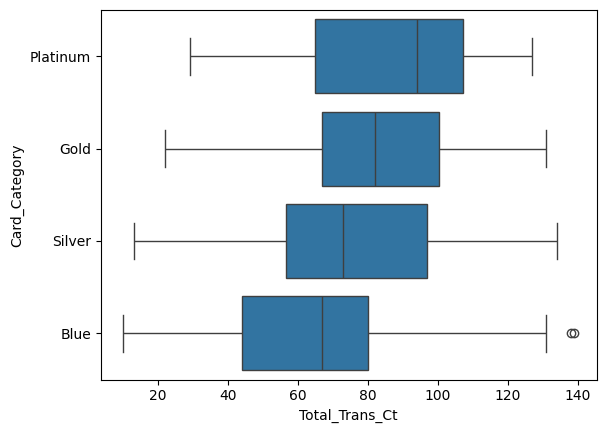

In [13]:
sb.boxplot(data=x, x='Total_Trans_Ct', y='Card_Category', orient='h', order=['Platinum','Gold','Silver','Blue'])
plt.show()

As we move up along the tier (from Blue to Platinum), the distribution of transactions moves to the right together with the median. Also, the range gets decreased as tier increases.

#### Credit Limit by Income Category

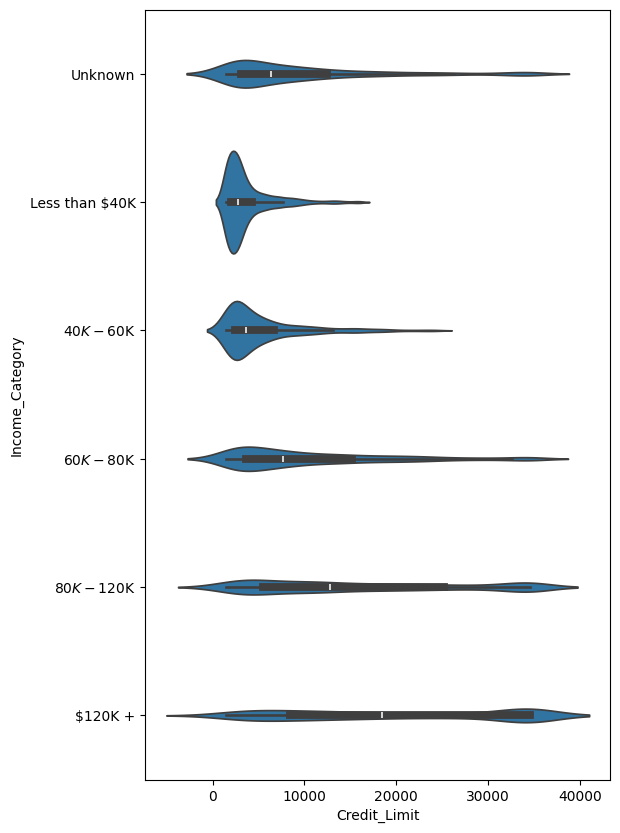

In [14]:
plt.figure(figsize = (6,10), dpi=100)
sb.violinplot(data=x, x='Credit_Limit', y='Income_Category', orient='h', order=['Unknown','Less than $40K','$40K - $60K','$60K - $80K','$80K - $120K','$120K +'])
plt.show()

The distribution of the credit limit is left-skewed for the lower income categories and as the income increases, the curve gets flattened, median increases and the range and the inter-quartile range increase. This is expected since customers with lower income have restrictions in the credit limits whereas customers with higher income have a wider range to select. 

#### Distribution of Customer_Age

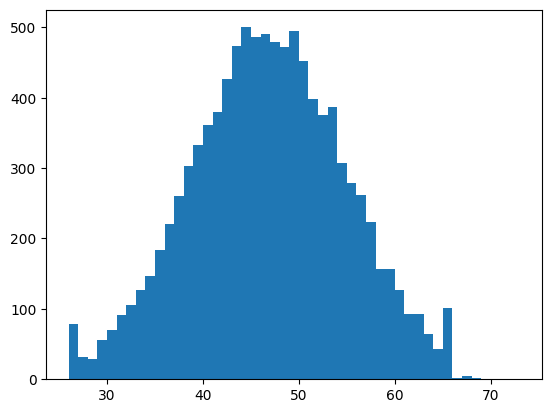

In [15]:
l1 = []
for i in np.arange(np.min(x.Customer_Age), np.max(x.Customer_Age) + 1, 1):
    l1.append(i)

plt.hist(x.Customer_Age, bins=l1)
plt.show()

The histogram of the age gives us a symmetric curve with mean and median approximately the same.

In [16]:
print(np.mean(x.Customer_Age))
print(np.median(x.Customer_Age))

46.32596030413745
46.0


# Data Preprocessing

### Splitting the dataset into Train and Test sets

To avoid any data leakage, splitting the dataset should be carried out before any data preprocessing

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=69, stratify=y)

#### Removing the ID column of the dataset

In [19]:
x_train.CLIENTNUM.sort_values(ascending=True)

9821    708082083
1589    708083283
4417    708084558
6148    708085458
6784    708086958
          ...    
365     828281733
5837    828285858
2996    828291858
777     828298908
3943    828343083
Name: CLIENTNUM, Length: 8101, dtype: int64

CLIENTNUM = Client Number. Unique identifier for the customer holding the account.

Since there is no evidence that the records are sequential, we remove CLIENTNUM column

In [20]:
x_train = x_train.drop(columns='CLIENTNUM')
x_test = x_test.drop(columns='CLIENTNUM')

#### Checking for any Null values

In [21]:
x_train.isnull().sum()

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

#### Checking for any Duplicates


In [22]:
x_train.duplicated().value_counts()

False    8101
Name: count, dtype: int64

In [23]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 4022 to 2426
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8101 non-null   int64  
 1   Gender                    8101 non-null   object 
 2   Dependent_count           8101 non-null   int64  
 3   Education_Level           8101 non-null   object 
 4   Marital_Status            8101 non-null   object 
 5   Income_Category           8101 non-null   object 
 6   Card_Category             8101 non-null   object 
 7   Months_on_book            8101 non-null   int64  
 8   Total_Relationship_Count  8101 non-null   int64  
 9   Months_Inactive_12_mon    8101 non-null   int64  
 10  Contacts_Count_12_mon     8101 non-null   int64  
 11  Credit_Limit              8101 non-null   float64
 12  Total_Revolving_Bal       8101 non-null   int64  
 13  Avg_Open_To_Buy           8101 non-null   float64
 14  Total_Amt_

After initial pre-processing steps, we now have a dataset with 19 features - 5 categorical variables and 14 numerical variables

### Feature-Encoding

Before categorical data can be utilized as input to a machine learning model, it must first be transformed into numerical data. There are multiple ways of handling Categorical variables. The two most widely used techniques:

    1. Label Encoding
    2. One-Hot Encoding

Label Encoding

A unique integer represents each value of the categorical variable. Issue with label encoding is that it can imply an unintended order to the variable. So, we use it only for ordinal variables of our dataset.

One-Hot Encoding

It simply creates additional features called dummy variables based on the number of unique values in the categorical feature. Every unique value in the category will be added as a feature. Issue with one-hot encoding is the Dummy Variable Trap - a scenario in which variables are highly correlated to each other - multicollinearity. So, in order to overcome the problem of multicollinearity, one of the dummy variables has to be dropped. We use one-hot encoding for nominal variables of our dataset.

#### Encoding Target Variable - Attrition_Flag

When we check the sizes of the classes of the target variable, we can clearly see that the dataset is imbalanced. But in this exercise we do not focus on any over-sampling or under-sampling. We conduct our classification exercise to the actual dataset.

In [24]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_train.value_counts()

Attrition_Flag
Existing Customer    6799
Attrited Customer    1302
Name: count, dtype: int64

Attrition_Flag is the target varibale so we just use replacement when encoding

In [25]:
y_train = y_train.replace({'Existing Customer':0, 'Attrited Customer':1})
y_test = y_test.replace({'Existing Customer':0, 'Attrited Customer':1})

y_train.value_counts()

Attrition_Flag
0    6799
1    1302
Name: count, dtype: int64

#### One-Hot Encoding Categorical Nominal Variables - Gender, Marital_Status

In [26]:
x_train.Gender.value_counts()

Gender
F    4270
M    3831
Name: count, dtype: int64

In [27]:
x_train.Marital_Status.value_counts()

Marital_Status
Married     3736
Single      3165
Divorced     601
Unknown      599
Name: count, dtype: int64

In [28]:
df1 = pd.get_dummies(x_train.loc[:, ['Gender','Marital_Status']], prefix=['Gender','Marital_Status'], drop_first=True)
x_train = pd.concat([x_train, df1], axis=1)
x_train = x_train.drop(columns={'Gender','Marital_Status'})

In [29]:
df2 = pd.get_dummies(x_test.loc[:, ['Gender','Marital_Status']], prefix=['Gender','Marital_Status'], drop_first=True)
x_test = pd.concat([x_test, df2], axis=1)
x_test = x_test.drop(columns={'Gender','Marital_Status'})

Before one-hot encoding Gender and Marital_Status variables, we had 19 variables in our dataset. After creating dummy variables, we had 23 variables and we dropped one dummy variable from each to overcome the problem of multicollinearity. Finally, we have 21 variables in our dataset.

#### Label Encoding Categorical Ordinal Variables - Education_Level, Income_Category, Card_Category

In [30]:
x_train.Education_Level.value_counts()

Education_Level
Graduate         2491
High School      1620
Unknown          1207
Uneducated       1176
College           815
Post-Graduate     425
Doctorate         367
Name: count, dtype: int64

In [31]:
x_train.Income_Category.value_counts()

Income_Category
Less than $40K    2818
$40K - $60K       1446
$80K - $120K      1231
$60K - $80K       1132
Unknown            894
$120K +            580
Name: count, dtype: int64

In [32]:
x_train.Card_Category.value_counts()

Card_Category
Blue        7534
Silver       457
Gold          92
Platinum      18
Name: count, dtype: int64

In [33]:
x_train.Education_Level = x_train.Education_Level.replace({'Unknown':0, 'Uneducated':1, 'High School':2, 'College':3, 'Graduate':4, 'Post-Graduate':5, 'Doctorate':6})
x_train.Income_Category = x_train.Income_Category.replace({'Unknown':0, 'Less than $40K':20000, '$40K - $60K':50000, '$60K - $80K':70000, '$80K - $120K':100000, '$120K +':140000})
x_train.Card_Category = x_train.Card_Category.replace({'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3})
x_train = x_train.reset_index(drop=True)

In [34]:
x_test.Education_Level = x_test.Education_Level.replace({'Unknown':0, 'Uneducated':1, 'High School':2, 'College':3, 'Graduate':4, 'Post-Graduate':5, 'Doctorate':6})
x_test.Income_Category = x_test.Income_Category.replace({'Unknown':0, 'Less than $40K':20000, '$40K - $60K':50000, '$60K - $80K':70000, '$80K - $120K':100000, '$120K +':140000})
x_test.Card_Category = x_test.Card_Category.replace({'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3})
x_test = x_test.reset_index(drop=True)

In [35]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8101 non-null   int64  
 1   Dependent_count           8101 non-null   int64  
 2   Education_Level           8101 non-null   int64  
 3   Income_Category           8101 non-null   int64  
 4   Card_Category             8101 non-null   int64  
 5   Months_on_book            8101 non-null   int64  
 6   Total_Relationship_Count  8101 non-null   int64  
 7   Months_Inactive_12_mon    8101 non-null   int64  
 8   Contacts_Count_12_mon     8101 non-null   int64  
 9   Credit_Limit              8101 non-null   float64
 10  Total_Revolving_Bal       8101 non-null   int64  
 11  Avg_Open_To_Buy           8101 non-null   float64
 12  Total_Amt_Chng_Q4_Q1      8101 non-null   float64
 13  Total_Trans_Amt           8101 non-null   int64  
 14  Total_Tr

After feature-encoding, we ended up with a dataset of 21 features, all numerical variables ready to be utilized to build a ML model.

### Feature-Reduction

Feature reduction techniques can help in identifying and retaining only the most informative features, reducing redundancy. We use different techniques based on the type of the features.

1. Continuous features with multi-collinearity - Principal Component Analysis (PCA)
2. Discrete or Categorical features - SelectKBest

Next, we should check for multi-collinearity in our dataset. Traditional correlation coefficients such as Pearson's correlation coefficient are designed for numerical-to-numerical relationships. Therefore, calculating the correlation between a numerical variable and a categorical variable directly is not meaningful. So, we only take numerical variables of our dataset and check for multi-collinearity. If multi-collinearity exists, we should perform PCA.

However, PCA is a dimensionality reduction technique commonly applied to continuous numeric variables. PCA is a rotation of data from one coordinate system to another. A common mistake is to apply PCA to non-continuous variables. While it is technically possible to use PCA on discrete variables, or categorical variables that have been encoded variables, we should not. So, we conduct PCA only on continuous variables.

#### Extracting Numerical Continuous Variables

In [36]:
x_train_cont = x_train.loc[:, ['Customer_Age','Months_on_book','Total_Revolving_Bal','Total_Trans_Amt','Months_Inactive_12_mon','Credit_Limit','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']]
x_test_cont = x_test.loc[:, ['Customer_Age','Months_on_book','Total_Revolving_Bal','Total_Trans_Amt','Months_Inactive_12_mon','Credit_Limit','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']]

#### Extracting Numerical Discrete Variables

In [37]:
x_train_disc = x_train.loc[:, ['Dependent_count','Total_Relationship_Count','Contacts_Count_12_mon','Total_Trans_Ct']]
x_test_disc = x_test.loc[:, ['Dependent_count','Total_Relationship_Count','Contacts_Count_12_mon','Total_Trans_Ct']]

#### Extracting Categorical Variables (after encoding)

In [38]:
x_train_cat = x_train.loc[:, ['Education_Level','Income_Category','Card_Category','Gender_M','Marital_Status_Married','Marital_Status_Single',
                      'Marital_Status_Unknown']]
x_test_cat = x_test.loc[:, ['Education_Level','Income_Category','Card_Category','Gender_M','Marital_Status_Married','Marital_Status_Single',
                      'Marital_Status_Unknown']]

#### Merging Numerical Variables

In [39]:
x_train_num = pd.concat([x_train_cont, x_train_disc], axis=1)

The variance inflation factor (VIF) is a measure used to assess multicollinearity in regression analysis. It is also calculated for numerical variables only. The general rule of thumb for interpreting VIF values is as follows:

    VIF = 1       : No multicollinearity. The variance of the coefficient is not inflated.

    1 < VIF <= 5  : Moderate multicollinearity. The variance of the coefficient is moderately inflated.

    VIF > 5       : High multicollinearity. The variance of the coefficient is highly inflated, suggesting a problematic level of correlation with other independent variables.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Variable"] = x_train_num.columns
vif["VIF"] = [variance_inflation_factor(x_train_num.values, i) for i in range(x_train_num.shape[1])]
vif

Both methods confirm that multi-collinearity exists in our dataset. So we need to perform PCA on the continuous variables.

#### Standardizing Continuous Variables before PCA

It is utterly important to carefully standardize your data because PCA works under the assumption that the data is normal distributed, and is very sensitive to the variance of the variables. Or in other words, large differences between the ranges of variables will dominate over those with small ranges.

In [43]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
x_train_cont_std = std.fit_transform(x_train_cont)
x_test_cont_std = std.fit_transform(x_test_cont)

#### Choosing best number of Components for PCA

We plot explained variance ratio and choose a number of components that "capture" at least 95% of the variance of the original dataset

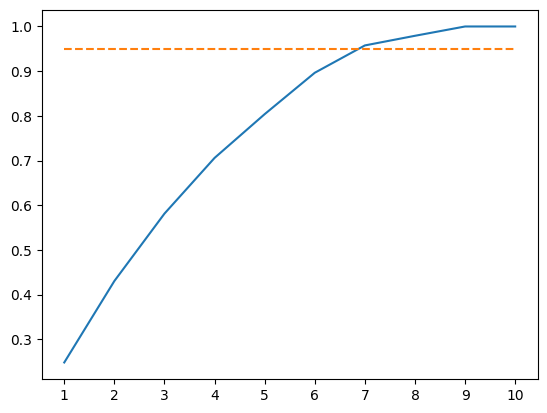

In [44]:
from sklearn.decomposition import PCA
pca10 = PCA(n_components=10)
pca10.fit(x_train_cont_std)
x_train_cont_pca = pca10.transform(x_train_cont_std)
    
l2 = []
for i in np.arange(1, 11, 1):
    l2.append(0.95)

plt.plot(np.arange(1, 11, 1), np.cumsum(pca10.explained_variance_ratio_))
plt.plot(np.arange(1, 11, 1), l2, ls='--')
plt.xticks(np.arange(1, 11, 1))
plt.show()

Based on the above graph, we select n_components = 7 to conduct our PCA

#### Conducting PCA on Standardized Continuous Variables

In [45]:
pca7_train = PCA(n_components=7)
pca7_train.fit(x_train_cont_std)
x_train_cont_pca = pca7_train.transform(x_train_cont_std)
x_train_pca = pd.DataFrame(x_train_cont_pca, columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7'])

In [46]:
pca7_test = PCA(n_components=7)
pca7_test.fit(x_test_cont_std)
x_test_cont_pca = pca7_test.transform(x_test_cont_std)
x_test_pca = pd.DataFrame(x_test_cont_pca, columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7'])

#### Merging Discrete and Categorical Variables

In [47]:
x_train_non_cont = pd.concat([x_train_disc, x_train_cat], axis=1)
x_test_non_cont = pd.concat([x_test_disc, x_test_cat], axis=1)

#### Performing SelectKBest on Discrete and Categorical Variables

SelectKBest is sensitive to the scale of the features, particularly when using scoring functions that are affected by feature magnitudes, such as the default function for classification, which is the chi-squared test. If our features have different scales, we should consider using scoring functions that are less sensitive to scale, such as mutual information or **f-classif**.

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(x_train_non_cont, y_train)

SelectKBest(k='all')

#### Calculating Scores of the Discrete and Categorical Variables based on SelectKBest

                     Feature        Score
0             Total_Trans_Ct  1283.192341
1      Contacts_Count_12_mon   359.974497
2   Total_Relationship_Count   185.248992
3                   Gender_M     7.022380
4     Marital_Status_Married     3.415960
5      Marital_Status_Single     2.464376
6            Income_Category     0.535813
7            Education_Level     0.491344
8            Dependent_count     0.233885
9              Card_Category     0.058307
10    Marital_Status_Unknown     0.007085


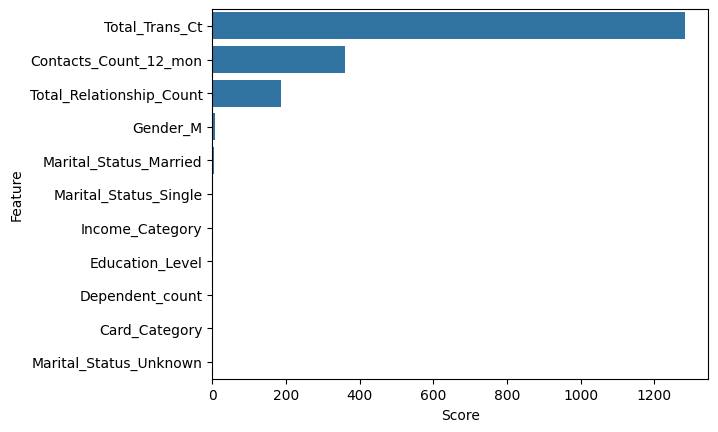

In [49]:
kbest_scores = pd.DataFrame({'Feature':x_train_non_cont.columns, 'Score':kbest.scores_})
kbest_scores.sort_values(by='Score', ascending=False, axis=0, inplace=True)
kbest_scores.reset_index(drop=True, inplace=True)
print(kbest_scores)
sb.barplot(data=kbest_scores, x='Score', y='Feature', orient='h')
plt.show()

#### Selecting the 4 Best Features based on SelectKBest

In [50]:
x_train_kbest = x_train_non_cont.loc[:, ['Total_Trans_Ct', 'Contacts_Count_12_mon', 'Total_Relationship_Count', 'Gender_M']]
x_test_kbest = x_test_non_cont.loc[:, ['Total_Trans_Ct', 'Contacts_Count_12_mon', 'Total_Relationship_Count', 'Gender_M']]

#### Merging the result datsets after PCA and SelectKBest

In [51]:
x_train_final = pd.concat([x_train_kbest, x_train_pca], axis=1)
x_train_final

,Total_Trans_Ct,Contacts_Count_12_mon,Total_Relationship_Count,Gender_M,pca1,pca2,pca3,pca4,pca5,pca6,pca7
0,64,2,4,True,0.096488,-0.135626,-0.198664,0.168579,-1.386073,-0.210081,-0.243395
1,42,3,3,True,3.278617,-0.223532,0.868490,-1.258725,0.967504,-1.481290,-1.527674
2,42,3,3,False,-0.053191,0.076082,-1.792534,-0.387965,0.508837,-0.284358,-0.387669
3,37,2,6,True,1.858103,0.845769,-0.048159,1.680935,0.897239,-1.026456,-0.387105
4,39,3,2,False,-2.280720,1.286093,-0.018306,-2.134931,-0.015873,-0.632172,-0.843226
...,...,...,...,...,...,...,...,...,...,...,...
8096,78,2,6,False,-0.432467,1.375799,-0.870789,0.640550,-0.330872,0.359217,0.595202
8097,43,3,5,False,-2.043817,0.632802,-0.846401,-1.276838,-0.288049,-0.319147,0.552615
8098,53,1,1,False,-2.220047,1.590077,-0.518820,-2.575904,-0.081349,-0.586548,-0.399670
8099,80,2,1,False,-1.409666,1.037881,-0.358971,-0.561609,-1.278977,0.078117,0.250147


In [52]:
x_test_final = pd.concat([x_test_kbest, x_test_pca], axis=1)
x_test_final

,Total_Trans_Ct,Contacts_Count_12_mon,Total_Relationship_Count,Gender_M,pca1,pca2,pca3,pca4,pca5,pca6,pca7
0,70,2,3,True,0.090906,-0.019786,-1.628159,-0.114362,0.549638,0.276791,-0.334274
1,62,2,5,True,1.544851,0.693231,-1.098780,0.276613,-1.351019,0.047359,0.314742
2,75,1,3,False,-1.313991,-0.556891,-0.255538,-0.761691,-0.388734,0.137940,0.062965
3,28,2,4,True,-1.210043,0.316579,0.085011,-0.115983,-1.114912,-1.029384,-0.572571
4,37,3,4,True,-0.815126,1.366687,-2.290487,-0.924990,-1.103551,-0.540711,-0.338800
...,...,...,...,...,...,...,...,...,...,...,...
2021,54,4,4,True,0.063859,0.860506,-2.397607,0.538338,0.520513,0.067698,-0.018015
2022,82,2,3,False,-0.333967,-0.308675,0.499394,0.477892,-0.402134,-0.001525,-0.450027
2023,52,2,3,False,-0.240237,0.054860,-1.004737,2.346757,1.174462,0.306401,0.730131
2024,30,1,6,True,-1.137208,0.531939,-0.594343,-0.402265,1.828226,-0.336263,-0.563495


We had a dataset of 7 components after the PCA and a dateset of 4 features after SelectKBest. By merging these 2 datasets, we ended up with a feature-reduced dataset with 11 features, ready to be used on multiple classifiers.

# Building Classification Model(s)

Now, we are going to perform the following Classifiers and pick the best in terms of the model score/accuracy.

### Single-module Methods

#### Decision Tree Classifier

In [53]:
from sklearn.tree import DecisionTreeClassifier
dt1 = DecisionTreeClassifier()
dt1.fit(x_train_final, y_train)
dt1.score(x_test_final, y_test)

0.9062191510365252

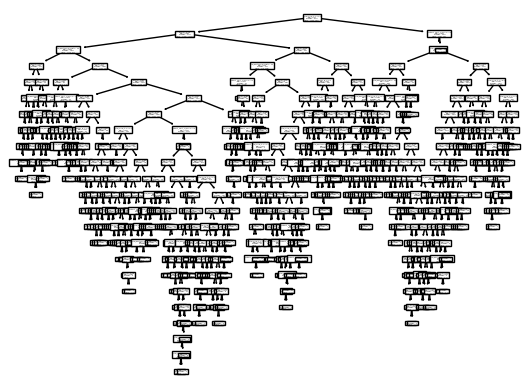

In [54]:
from sklearn.tree import plot_tree

l3 = []
for i in x_train_final.columns:
    l3.append(i)
    
plot_tree(dt1, feature_names=l3)
plt.show()

#### KNN Classifier

In [55]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier(n_neighbors=6, metric='minkowski', p=2)
knn1.fit(x_train_final, y_train)
knn1.score(x_test_final, y_test)

0.918558736426456

#### Naive Bayes Classifier

In [56]:
from sklearn.naive_bayes import GaussianNB
nb1 = GaussianNB()
nb1.fit(x_train_final, y_train)
nb1.score(x_test_final, y_test)

0.8899308983218164

#### SVM Classifier

In [57]:
from sklearn.svm import SVC
svm1 = SVC(kernel='linear', random_state=69)
svm1.fit(x_train_final, y_train)
svm1.score(x_test_final, y_test)

0.9076999012833169

### Ensemble Methods

#### Random Forest Regressor

In [58]:
from sklearn.ensemble import RandomForestRegressor
rfr1 = RandomForestRegressor(n_estimators=1000, random_state=69)
rfr1.fit(x_train_final, y_train)
rfr1.score(x_test_final, y_test)

0.6592752744756478

#### Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier
rfc1 = RandomForestClassifier(n_estimators=1000, oob_score=True)
rfc1.fit(x_train_final, y_train)
rfc1.score(x_test_final, y_test)

0.9442250740375123

#### Bagging Classifier

In [60]:
from sklearn.ensemble import BaggingClassifier
bag1 = BaggingClassifier(n_estimators=1000, random_state=69) # DecisionTreeClassifier by default
bag1.fit(x_train_final, y_train)
bag1.score(x_test_final, y_test)

0.9387956564659428

#### Ada Boost Classifier

In [61]:
from sklearn.ensemble import AdaBoostClassifier
ada1 = AdaBoostClassifier(n_estimators=1000, learning_rate=0.05)
ada1.fit(x_train_final, y_train)
ada1.score(x_test_final, y_test)

/home/sesamm/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.9333662388943732

#### XGB Classifier

In [62]:
from xgboost import XGBClassifier
xgb1 = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb1.fit(x_train_final, y_train)
xgb1.score(x_test_final, y_test)

0.9447186574531096

#### Calculating Feature Importance using XGB Classifier

{'Total_Trans_Ct': 8.211719512939453, 'Contacts_Count_12_mon': 2.1257874965667725, 'Total_Relationship_Count': 6.218653202056885, 'Gender_M': 1.7075462341308594, 'pca1': 1.9034423828125, 'pca2': 1.208046317100525, 'pca3': 2.1087889671325684, 'pca4': 1.422380805015564, 'pca5': 1.3265995979309082, 'pca6': 4.232004165649414, 'pca7': 1.4299817085266113}


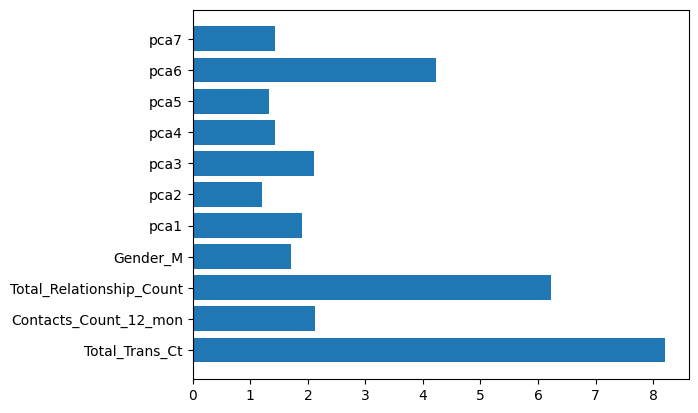

In [63]:
d1 = xgb1.get_booster().get_score(importance_type='gain')
print(d1)
plt.barh(x_train_final.columns, d1.values())
plt.show()

#### Generating Confusion Matrix for XGB Classifier

In [64]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_xgb1 = xgb1.predict(x_test_final)
cf = pd.DataFrame(confusion_matrix(y_test, y_pred_xgb1), columns=['Existing Customer - predicted','Attrited Customer - predicted'], index=['Existing Customer - actual','Attrited Customer - actual'])
cf

,Existing Customer - predicted,Attrited Customer - predicted
Existing Customer - actual,1654,47
Attrited Customer - actual,65,260
